<a href="https://colab.research.google.com/github/kalyanimaruveni7/osteoporosis-prediction-ml/blob/main/osteoporosis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Cleaned columns:
 ['S.No', 'Patient_Id', 'Joint_Pain', 'Gender', 'Age', 'Menopause_Age', 'height_(meter)', 'Weight_(KG)', 'Smoker', 'Alcoholic', 'Diabetic', 'Hypothyroidism', 'Number_of_Pregnancies', 'Seizer_Disorder', 'Estrogen_Use', 'Occupation', 'History_of_Fracture', 'Dialysis', 'Family_History_of_Osteoporosis', 'Maximum_Walking_distance_(km)', 'Daily_Eating_habits', 'Medical_History', 'T-score_Value', 'Z-Score_Value', 'BMI', 'Site', 'Obesity', 'Diagnosis']
✅ Missing values handled
✅ Data balanced:  {0: 194, 1: 194}
✅ Best Model Parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

📈 Model Evaluation Metrics:
✅ Accuracy      : 98.72%
✅ F1 Score      : 0.987
✅ Sensitivity   : 1.000
✅ Specificity   : 0.974
✅ ROC-AUC Score : 1.000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        39
           1       0.97      1.00      0.99        39

    accuracy           

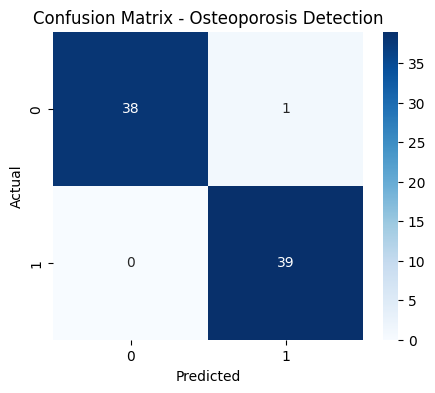

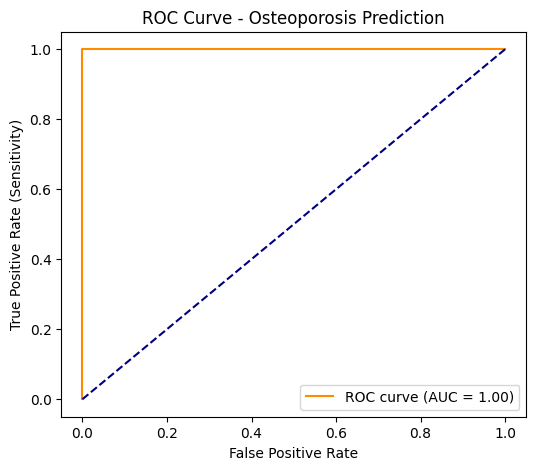

In [15]:
# --------------------------------------------
# 📦 Import Libraries
# --------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_curve, roc_auc_score, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# --------------------------------------------
# 🩺 Load Dataset
# --------------------------------------------

data = pd.read_csv(r"/content/Copy of patient details (1).csv")



# --------------------------------------------
# 🧹 Clean Column Names
# --------------------------------------------
data.columns = (
    data.columns.str.strip()
    .str.replace(":", "", regex=False)
    .str.replace(" ", "_")
    .str.replace("__", "_")
)
print("✅ Cleaned columns:\n", data.columns.tolist())

# --------------------------------------------
# 🏷️ Define Target Column
# --------------------------------------------
target_col = "Diagnosis"

# --------------------------------------------
# 🧩 Drop Unnecessary Columns
# --------------------------------------------
drop_cols = ["S.No", "Patient_Id"]
data = data.drop(columns=[col for col in drop_cols if col in data.columns])

# --------------------------------------------
# 🧼 Handle Missing Values
# --------------------------------------------
for col in data.select_dtypes(include=[np.number]).columns:
    data[col] = data[col].fillna(data[col].median())

for col in data.select_dtypes(include=["object"]).columns:
    data[col] = data[col].fillna(data[col].mode()[0])

print("✅ Missing values handled")

# --------------------------------------------
# 🎯 Separate Features and Target
# --------------------------------------------
X = data.drop(columns=[target_col])
y = data[target_col].astype(str)

# Encode target
y = y.map(lambda val: 1 if val.lower() in ['yes', 'positive', 'osteoporosis', 'affected'] else 0)

# --------------------------------------------
# 🔢 Encode Categorical Variables
# --------------------------------------------
X = pd.get_dummies(X, drop_first=True)

# --------------------------------------------
# ⚖️ Balance Dataset (Handle Imbalance)
# --------------------------------------------
X['Diagnosis'] = y
minority = X[X.Diagnosis == 1]
majority = X[X.Diagnosis == 0]

minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)
balanced = pd.concat([majority, minority_upsampled])

y = balanced['Diagnosis']
X = balanced.drop(columns=['Diagnosis'])

print("✅ Data balanced: ", y.value_counts().to_dict())

# --------------------------------------------
# ⚙️ Scale Features
# --------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------
# 🔀 Train/Test Split
# --------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------------------------
# 🌲 Model Training (Optimized Random Forest)
# --------------------------------------------
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [8, 10, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
model = grid.best_estimator_

print("✅ Best Model Parameters:", grid.best_params_)

# --------------------------------------------
# 📊 Evaluation
# --------------------------------------------
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Sensitivity (Recall) and Specificity
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\n📈 Model Evaluation Metrics:")
print(f"✅ Accuracy      : {acc*100:.2f}%")
print(f"✅ F1 Score      : {f1:.3f}")
print(f"✅ Sensitivity   : {sensitivity:.3f}")
print(f"✅ Specificity   : {specificity:.3f}")
print(f"✅ ROC-AUC Score : {auc:.3f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --------------------------------------------
# 🔵 Confusion Matrix
# --------------------------------------------
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Osteoporosis Detection")
plt.show()

# --------------------------------------------
# 🔴 ROC Curve
# --------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - Osteoporosis Prediction")
plt.legend(loc="lower right")
plt.show()

# --------------------------------------------
# 🧠 Predict New Patient
# --------------------------------------------
def predict_patient_input():
    print("\n🧍 Enter patient details below:")
    input_data = {}
    for col in X.columns:
        val = float(input(f"{col}: ")) if "_Yes" not in col and "_Positive" not in col else int(input(f"{col} (0/1): "))
        input_data[col] = val

    df = pd.DataFrame([input_data])
    df_scaled = scaler.transform(df)
    pred = model.predict(df_scaled)[0]
    print("\n🩺 Prediction: ", "Osteoporosis Detected 🧬" if pred == 1 else "No Osteoporosis ✅")

# Uncomment below line to allow manual input
# predict_patient_input()


UI

In [17]:
import pickle

# Save model, scaler, and features
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

print("✅ Model saved successfully!")

✅ Model saved successfully!
